In [18]:
from IPython.display import display, Math, Latex

This notebook is mostly a proof of concept with creating random walks and approximating the heat kernel.

# Python

### Terminal

Macs come preinstalled with python and pip3. Usually if you need a library or package it suffices to go into terminal and write:

pip3 install numpy matplotlib geomstats

For this project if you just copy and paste the above you should have everything you need. 

If you have PC idk :(

### Python Things

Although there are python functions like sqrt, log, etc. If you're ever working with a list it's best to use numpy. To perfom operations on arrays, you must first convert whatever list you have into a numpy array ex: "" your_list = np.array( your_list ) "", then you can perform whatever operations you want in numpy ex: "" np.sqrt( your_list ) "".

You may also see gs.func(xxx) geomstats uses numpy backend so it's basically the same thing as just calling np.func(xxx).

If you ever need to plot something. Don't bother trying to learn how to use matplotlib, just ask ChatGPT.

# Jupyter Lab Tutorial

Jupyter Lab is just a place where we can run python scripts. It makes it easier to read and collaborate with others. For example, these "markdown" cells that make notes look a lot better. In addition, we can write math notation and we can easily organize our notebooks.

### Useful Keyboard Shortcuts:

Shift + Enter : Run Cell + Move to cell below

Command + Enter : Run current cell

X : Delete Cell

B : Add cell below

A : Add cell above

M : Turn cell into markdown cell "comment cell'

Command + Z : undo

### Math Notation

You can write math notation like in Latex if you use dollar signs (double click on the formula to see, then re-run the cell):

$$
K(t, x, y) = \frac{1}{(4\pi t)^{d/2}}\exp\left({-\frac{||x-y||^2}{4t}}\right)
$$

### Markdown Cells

Markdown cells allows you to write notes like this one.

Click on the cell then click "M" to turn the current cell into a markdown cell.

Clicking 1, 2, 3, 4, or 5 while on the markdown cell allows you to make headings like the ones above. 

# Math

### Formulas/Definitions

Heat Kernel:
$$
K(t, x, y) = \frac{1}{(4\pi t)^{d/2}} \exp \left( -\frac{||x-y||^2}{4t} \right)
$$
Varadhan's Formula:
$$
||x-y||^2 = \lim_{t\to0} \left[-4t\log(K(t,x,y))\right]
$$
Random Walk:
$$
S_n = X_0 + X_1 + \cdots + X_n
$$
Wiener Process (Process that describes Brownian Motion):
$$
W_0 = 0
$$
$$
W_i\text{ is independent of }W_j \quad \forall i,j
$$
$$
W_{t+u} - W_t \text{ has mean 0 and variance } u
$$
$$
W_t \text{ is continuous in }t
$$

# The Code 

In [21]:
# importing dependencies
import numpy as np
import matplotlib.pyplot as plt
import geomstats.backend as gs
import geomstats.geometry.euclidean as euclidean
from scipy.ndimage import gaussian_filter

### Random Walks and Heat Equation

This is similar to algorithm 1 that we saw in the research paper, but since we are only in euclidean space we aren't doing the retractions we're using the exponential map which allows us to map points onto a manifold. This will be changed to the retraction based method when we move to manifolds.

An important note is that 'simulate_random_walks' only returns the endpoints of the random walk.

In [7]:
dim = 2
space = euclidean.Euclidean(dim=dim)

# function that returns array of endpoints for random walks
def simulate_random_walks(start_point, num_walks, num_steps, step_size):
    endpoints = []
    for _ in range(num_walks):
        current_point = start_point
        for __ in range(num_steps):
            step = gs.array(np.random.normal(0, step_size, dim))
            current_point = space.metric.exp(step, current_point)
        endpoints.append(current_point)
    return gs.array(endpoints)

num_walks = 100000
num_steps = 50
x = 0 
t = 1
step_size = np.sqrt(2 * t**2 / num_steps)


endpoints = simulate_random_walks(np.array([0, 0]), num_walks, num_steps, step_size)

Heat Kernel $x,y$ are points $(x_1,...,x_n)$ in some higher dimensional space:
$$
K(t,x,y) = \frac{1}{(4\pi t)^{d/2}} \exp (-\frac{||x-y||^2}{4t})
$$
Below we are flattening our values so it goes from a list of pairs of points $((x_1,x_2), (y_1,y_2)) \to (x_1,x_2,y_1,y_2)$ since the process acting on $x$ and $y$ are identical so they should each look like a gaussian. We then plot it on a histogram that is divided up into intervals. So the value at each interval will be the number of $x,y$ that ended up in that interval. This is what gives us the bell curve looking shape below.

In [19]:
# dividing the interval (-5,5) into 1000 equally spaced subintervals. 
bins = np.linspace(-5, 5, 1000)

kernel_density, _ = np.histogram(endpoints.flatten(), bins=bins, density=True)

# smoothing function
smoothed_kernel_density = gaussian_filter(kernel_density, sigma=1)

# formula for heat kernel
def analytical_heat_kernel_1d(t, x, y):
    """Compute the 1D heat kernel for points x and y and time t."""
    return 1 / np.sqrt(4 * np.pi * t) * np.exp(-((x - y) ** 2) / (4 * t))

analytical_values = np.array([analytical_heat_kernel_1d(t, x, y) for y in bins])

Histogram method of finding kernel values with a smoothing function (gaussian filter):

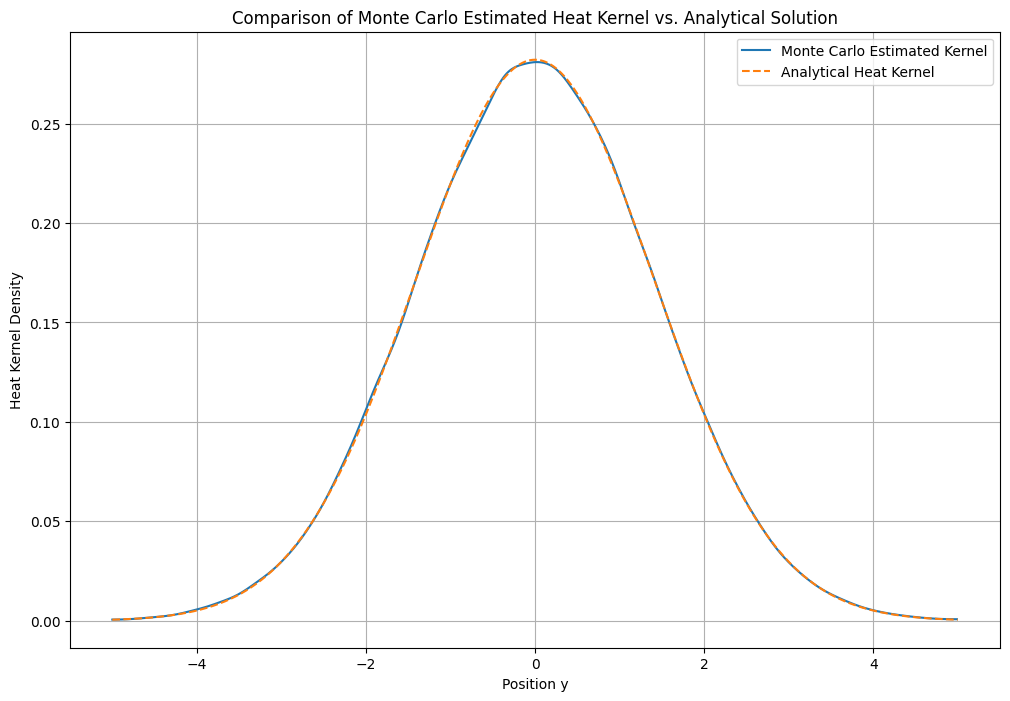

In [20]:
# plotting
smoothed_kernel_density = gaussian_filter(kernel_density, sigma=14)
plt.figure(figsize=(12, 8))
plt.plot(bins[:-1], smoothed_kernel_density, label='Monte Carlo Estimated Kernel')
plt.plot(bins, analytical_values, label='Analytical Heat Kernel', linestyle='--')
plt.title('Comparison of Monte Carlo Estimated Heat Kernel vs. Analytical Solution')
plt.xlabel('Position y')
plt.ylabel('Heat Kernel Density')
plt.legend()
plt.grid(True)
plt.show()

We take the interpolated values for each subinterval (interpolated ~ linearized each subinterval). Then took the mean squared error between the real heat kernel and the approximation.

In [22]:
# calculating error
analytical_values_interpolated = np.interp(bins[:-1], bins, analytical_values)
mse = np.mean((smoothed_kernel_density - analytical_values_interpolated) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 7.073171011703237e-07


We can see that the random walks model diffusion nicely.

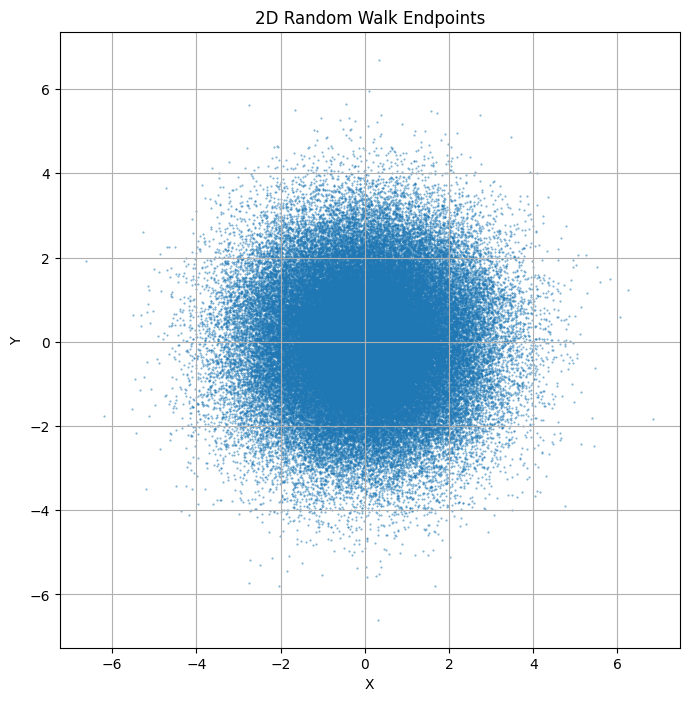

In [17]:
# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(endpoints[:, 0], endpoints[:, 1], marker='.', alpha=0.6, s=1)
plt.title('2D Random Walk Endpoints')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal') 
plt.grid(True)
plt.show()

In [11]:
def get_density_at_point(y_point, bins, densities):
    bin_index = np.digitize([y_point], bins) - 1  # Find bin for the point
    bin_index = min(max(bin_index[0], 0), len(densities) - 1)  # Clamp index to valid range
    return densities[bin_index]


y_point = 0
density_at_point = get_density_at_point(y_point, bins, smoothed_kernel_density)
print("Density at y =", y_point, "is", density_at_point)

Density at y = 0 is 0.2808677953503939
